In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing libraries**

In [ ]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import multiprocessing
from multiprocessing.pool import ThreadPool
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


In [ ]:
%cd /content/drive/My\ Drive/aptos2019-blindness-detection

/content/drive/My Drive/aptos2019-blindness-detection


# **Loading dataset**

In [ ]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/train_images')
    test_dir = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/test_images')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/aptos2019-blindness-det...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/aptos2019-blindness-det...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/aptos2019-blindness-det...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/aptos2019-blindness-det...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/aptos2019-blindness-det...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/aptos2019-blindness-det...,0083ee8054ee.png


In [ ]:
df_test.head(6)

,id_code,file_path,file_name
0,0005cfc8afb6,/content/drive/MyDrive/aptos2019-blindness-det...,0005cfc8afb6.png
1,003f0afdcd15,/content/drive/MyDrive/aptos2019-blindness-det...,003f0afdcd15.png
2,006efc72b638,/content/drive/MyDrive/aptos2019-blindness-det...,006efc72b638.png
3,00836aaacf06,/content/drive/MyDrive/aptos2019-blindness-det...,00836aaacf06.png
4,009245722fa4,/content/drive/MyDrive/aptos2019-blindness-det...,009245722fa4.png
5,009c019a7309,/content/drive/MyDrive/aptos2019-blindness-det...,009c019a7309.png


In [ ]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show()

# **Class Distribution**

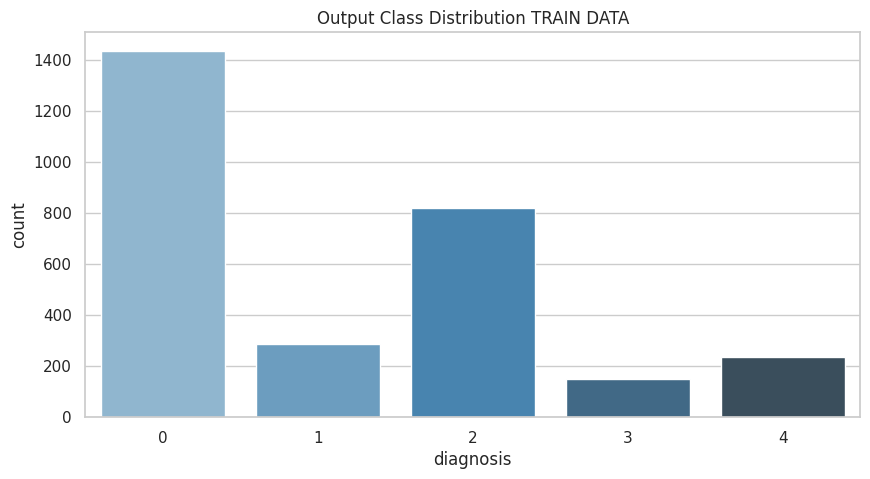

In [ ]:
plot_classes(df_train_train,"TRAIN DATA")

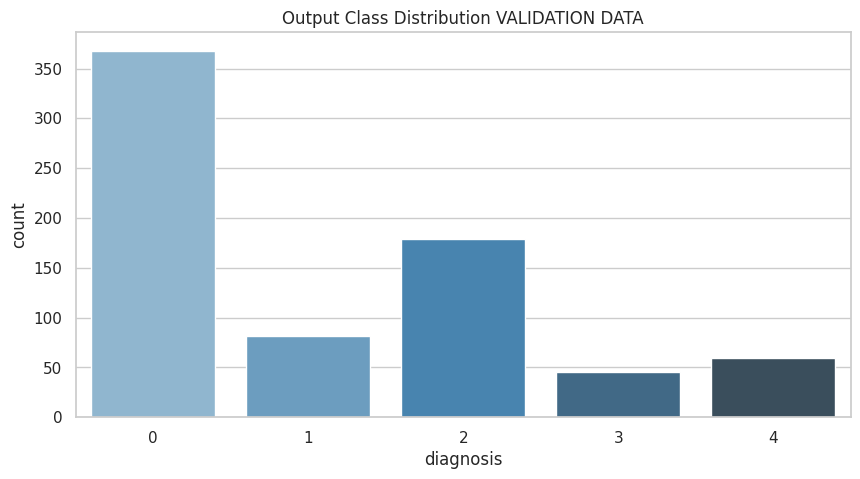

In [ ]:
plot_classes(df_train_test,'VALIDATION DATA')

In [ ]:
file = open('df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('df_train_test', 'wb')
pickle.dump(df_train_test, file)
file.close()

In [ ]:
file = open('df_train_train', 'rb')
df_train_train = pickle.load(file)
file.close()

file = open('df_train_test', 'rb')
df_train_test = pickle.load(file)
file.close()

# **Train, test Images rezied**

In [ ]:
IMG_SIZE  = 512

In [ ]:
import os
import cv2
import pandas as pd

def image_resize_save(file, input_dir, output_dir):
    input_filepath = os.path.join(input_dir, f'{file}.png')
    output_filepath = os.path.join(output_dir, f'{file}.png')
    img = cv2.imread(input_filepath)
    if img is not None:
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(output_filepath, resized_img)
    else:
        print(f"Failed to read image: {input_filepath}")

# Directories
input_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
output_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Resize and save all images
for file in df_train.id_code:
    image_resize_save(file, input_dir, output_dir)

print("All images have been resized and saved.")


All images have been resized and saved.


In [ ]:
import os
import cv2
import pandas as pd

def image_resize_save(file, input_dir, output_dir):
    input_filepath = os.path.join(input_dir, f'{file}.png')
    output_filepath = os.path.join(output_dir, f'{file}.png')
    img = cv2.imread(input_filepath)
    if img is not None:
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(output_filepath, resized_img)
    else:
        print(f"Failed to read image: {input_filepath}")

# Directories
input_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images'
output_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images_resized'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Resize and save all images
for file in df_test.id_code:
    image_resize_save(file, input_dir, output_dir)

print("All images have been resized and saved.")


All images have been resized and saved.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define your IMG_SIZE if not defined
#IMG_SIZE = 224

# Define your cropping functions
def crop_image_from_gray(img, tol=7):
    if img is None:
        return None
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    """Create circular crop around image centre."""
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(file, input_dir, output_dir):
    input_filepath = os.path.join(input_dir, file)
    output_filepath = os.path.join(output_dir, file)

    img = cv2.imread(input_filepath)
    if img is not None:
        img = circle_crop(img)
        if img is not None:
            cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        else:
            print(f"Skipping image: {input_filepath} (cropping failed)")
    else:
        print(f"Failed to read image: {input_filepath}")

# Specify the directories
input_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized'
output_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized_preprocessed'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get the list of filenames in the input directory
filenames = os.listdir(input_dir)

# Preprocess all images using tqdm for progress indication
for file in tqdm(filenames):
    preprocess_image(file, input_dir, output_dir)

print("All images have been preprocessed.")

100%|██████████| 3662/3662 [19:31<00:00,  3.12it/s]

All images have been preprocessed.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define your IMG_SIZE if not defined
#IMG_SIZE = 224

# Define your cropping functions
def crop_image_from_gray(img, tol=7):
    if img is None:
        return None
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    """Create circular crop around image centre."""
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(file, input_dir, output_dir):
    input_filepath = os.path.join(input_dir, file)
    output_filepath = os.path.join(output_dir, file)

    img = cv2.imread(input_filepath)
    if img is not None:
        img = circle_crop(img)
        if img is not None:
            cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        else:
            print(f"Skipping image: {input_filepath} (cropping failed)")
    else:
        print(f"Failed to read image: {input_filepath}")

# Specify the directories
input_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images_resized'
output_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images_resized_preprocessed'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get the list of filenames in the input directory
filenames = os.listdir(input_dir)

# Preprocess all images using tqdm for progress indication
for file in tqdm(filenames):
    preprocess_image(file, input_dir, output_dir)

print("All images have been preprocessed.")


100%|██████████| 1928/1928 [10:44<00:00,  2.99it/s]

All images have been preprocessed.


In [ ]:
import os

def count_images_in_folder(folder_path, extensions=['.png', '.jpg', '.jpeg']):
    # List all files in the directory
    all_files = os.listdir(folder_path)

    # Filter files based on the provided extensions
    image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in extensions]

    return len(image_files), image_files

# Specify the directory containing your images
folder_path = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images_resized_preprocessed'

# Count images
num_images, image_files = count_images_in_folder(folder_path)

print(f"Number of images in folder: {num_images}")


Number of images in folder: 1928


# **Training**

In [ ]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Colab Libs...
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

2  CPU cores


In [ ]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()

    return df_train_train,df_train_test

In [ ]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
742,357f02a779d7,0,/content/drive/MyDrive/aptos2019-blindness-det...,357f02a779d7.png
299,1638404f385c,4,/content/drive/MyDrive/aptos2019-blindness-det...,1638404f385c.png
2074,91b6ebaa3678,3,/content/drive/MyDrive/aptos2019-blindness-det...,91b6ebaa3678.png
973,4554062fa836,0,/content/drive/MyDrive/aptos2019-blindness-det...,4554062fa836.png
259,13c191b59ed0,0,/content/drive/MyDrive/aptos2019-blindness-det...,13c191b59ed0.png
3601,fb88783de055,0,/content/drive/MyDrive/aptos2019-blindness-det...,fb88783de055.png


In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 50
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)

    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)

    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import ResNet50

# Ensure these variables are defined
#HEIGHT = 224
#WIDTH = 224
#CANAL = 3
#N_CLASSES = 10

def create_model(input_shape, n_out):
	input_tensor = Input(shape=input_shape)
	base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)

	# Add the custom layers on top of the base model
	x = GlobalAveragePooling2D()(base_model.output)
	x = Dropout(0.5)(x)
	x = Dense(2048, activation='relu')(x)
	x = Dropout(0.5)(x)
	final_output = Dense(n_out, activation='softmax', name='final_output')(x)

	model = Model(input_tensor, final_output)

	return model

# Create the model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Load custom weights
try:
	model.load_weights("/content/drive/MyDrive/aptos2019-blindness-detection/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", by_name=True)
	print("Weights loaded successfully.")
except Exception as e:
	print(f"Error loading weights: {e}")

# Freeze all layers initially
for layer in model.layers:
	layer.trainable = False

# Unfreeze the last 5 layers
for layer in model.layers[-5:]:
	layer.trainable = True

# Print the model summary
model.summary()

Weights loaded successfully.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                             

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [ ]:
from keras import optimizers



model.compile(optimizer=optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

history_warmup = model.fit(
	train_generator,
	steps_per_epoch=STEP_SIZE_TRAIN,
	validation_data=valid_generator,
	validation_steps=STEP_SIZE_VALID,
	epochs=WARMUP_EPOCHS,
	verbose=1
).history

Epoch 1/2
293/293 [==============================] - 2302s 8s/step - loss: 1.7383 - accuracy: 0.5422 - val_loss: 1.5498 - val_accuracy: 0.5017
Epoch 2/2
293/293 [==============================] - 69s 234ms/step - loss: 1.0252 - accuracy: 0.6532 - val_loss: 7.7534 - val_accuracy: 0.4349


In [ ]:
for layer in model.layers:
    layer.trainable = True

#es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
#rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = []
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
history_finetunning = model.fit(train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=EPOCHS,
                                callbacks=callback_list,
                                verbose=1).history

Epoch 1/50
293/293 [==============================] - 1410s 5s/step - loss: 0.3796 - accuracy: 0.6007 - val_loss: 0.4526 - val_accuracy: 0.3442
Epoch 2/50
293/293 [==============================] - 68s 232ms/step - loss: 0.3130 - accuracy: 0.6715 - val_loss: 0.6779 - val_accuracy: 0.2705
Epoch 3/50
293/293 [==============================] - 68s 233ms/step - loss: 0.2892 - accuracy: 0.7031 - val_loss: 0.2943 - val_accuracy: 0.6592
Epoch 4/50
293/293 [==============================] - 70s 238ms/step - loss: 0.2786 - accuracy: 0.7090 - val_loss: 0.4727 - val_accuracy: 0.3716
Epoch 5/50
293/293 [==============================] - 67s 229ms/step - loss: 0.2743 - accuracy: 0.7120 - val_loss: 0.8624 - val_accuracy: 0.5017
Epoch 6/50
293/293 [==============================] - 68s 232ms/step - loss: 0.2585 - accuracy: 0.7201 - val_loss: 0.3430 - val_accuracy: 0.6558
Epoch 7/50
293/293 [==============================] - 70s 238ms/step - loss: 0.2585 - accuracy: 0.7210 - val_loss: 0.6306 - val_acc

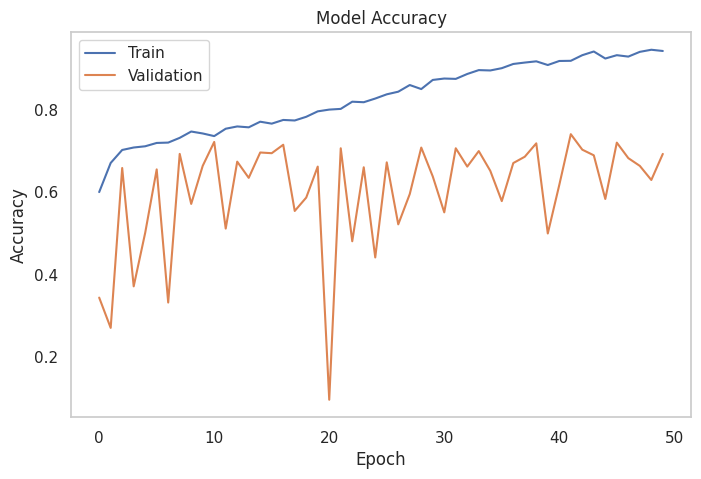

In [ ]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/aptos2019-blindness-detection/diabetic_retinopathy_model'

# Save the model in the TensorFlow SavedModel format
model.save(save_path)
print(f"Model saved in TensorFlow SavedModel format to {save_path}")


Model saved in TensorFlow SavedModel format to /content/drive/MyDrive/aptos2019-blindness-detection/diabetic_retinopathy_model


In [ ]:
# Define the path to save the model in h5 format
h5_save_path = '/content/drive/MyDrive/aptos2019-blindness-detection/diabetic_retinopathy_model11.h5'

# Save the model in h5 format
model.save(h5_save_path)
print(f"Model saved in h5 format to {h5_save_path}")


Model saved in h5 format to /content/drive/MyDrive/aptos2019-blindness-detection/diabetic_retinopathy_model11.h5


# **Generate Train Predictions on complete Train Data**

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "/content/drive/MyDrive/aptos2019-blindness-detection/train_images_resized_preprocessed",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.
2929/2929 [==============================] - 54s 18ms/step


In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.862
Train Accuracy score : 0.847


# **Evaluate Model on Test Data**

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

163/733 [=====>........................] - ETA: 5:16

In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)

    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

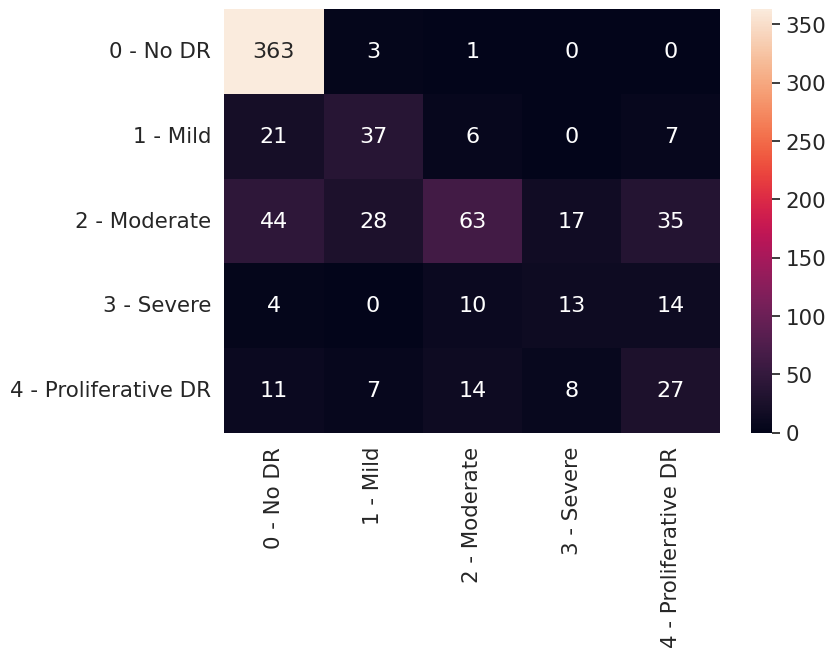

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

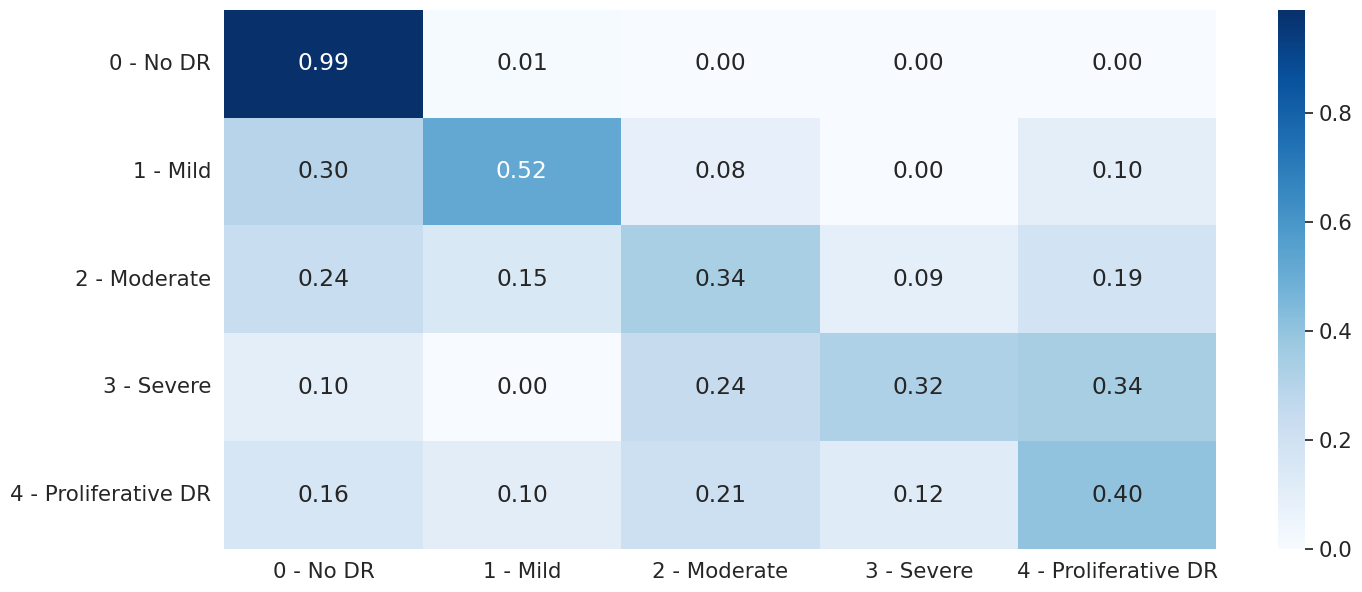

In [ ]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.703
Test Accuracy score : 0.686
